In [1]:
%pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc pandas scikit-learn chembl_webresource_client

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Load Parkinson's dataset
data = fetch_openml(name="parkinsons", version=1, as_frame=True)
df = data.frame

# Extract features (X) and labels (y)
X = df.drop(columns=["Class"]).values
y = df["Class"].values  # labels: 1 = Parkinson's, 0 = healthy

# Convert labels {'1','2'} to {-1,1}
y = np.where(y == '1', -1, 1)


print("Original X.shape =", X.shape, ", y.shape =", y.shape)

# ===============================================
# STEP 1: Select balanced subset of samples (90)
# ===============================================

p_idx = np.where(y == 1)[0]
h_idx = np.where(y == -1)[0]

subset_p = 45   # half
subset_h = 45   # half

p_sel = np.random.choice(p_idx, size=subset_p, replace=False)
h_sel = np.random.choice(h_idx, size=subset_h, replace=False)
selected_idx = np.concatenate([p_sel, h_sel])

X = X[selected_idx]
y = y[selected_idx]

print("After balanced sample subset X.shape =", X.shape)
print("Label distribution:", np.unique(y, return_counts=True))

# ===============================================
# STEP 2 (Alternative): PCA for feature reduction
# ===============================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

num_components = 10   # principal components to keep

# PCA는 scale에 민감 → 먼저 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=num_components, svd_solver='full')
X = pca.fit_transform(X_scaled)

print("Explained variance ratio sum =", np.sum(pca.explained_variance_ratio_))
print("After PCA transformation X.shape =", X.shape)


# ===============================================
# STEP 3: Scale X to [-pi, pi]
# ===============================================
X_min = np.min(X)
X_max = np.max(X)
X = (X - X_min) / (X_max - X_min) * 2*np.pi

# ===============================================
# STEP 4: Train/Test split: 60 train, 30 test
# ===============================================
from sklearn.model_selection import train_test_split

X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, train_size=60, test_size=30,
    random_state=SEED, stratify=y
)

print("X_train.shape =", X_train.shape, ", X_test.shape =", X_test.shape)
print("Train label dist:", np.unique(train_labels, return_counts=True))
print("Test label dist:", np.unique(test_labels, return_counts=True))

Original X.shape = (195, 22) , y.shape = (195,)
After balanced sample subset X.shape = (90, 22)
Label distribution: (array([-1,  1]), array([45, 45]))
Explained variance ratio sum = 0.9836877128835112
After PCA transformation X.shape = (90, 10)
X_train.shape = (60, 10) , X_test.shape = (30, 10)
Train label dist: (array([-1,  1]), array([30, 30]))
Test label dist: (array([-1,  1]), array([15, 15]))


In [3]:
from qiskit.circuit.library import efficient_su2

num_features = np.shape(X_train)[1]
num_qubits = num_features
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.

from qiskit.circuit.library import PauliFeatureMap
fm = PauliFeatureMap(num_qubits, reps=2, paulis=['X', 'Z', 'ZZ'])


training done
test matrix done


Text(0.5, 1.0, 'test matrix')

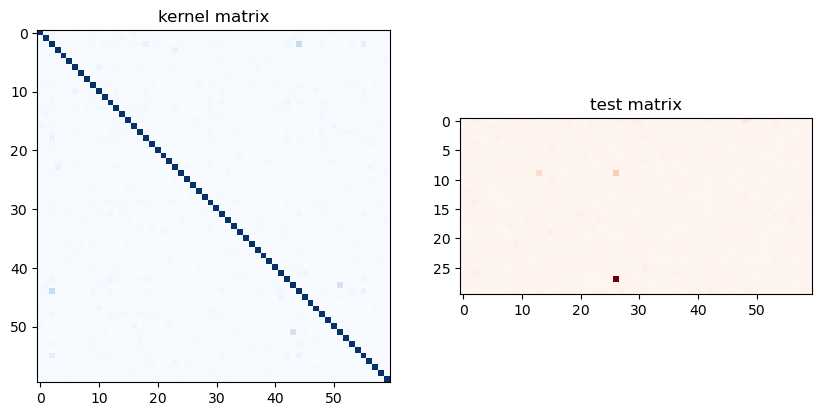

In [4]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap
 
num_shots = 10000

sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

In [5]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel}")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel}")

Quantum SVC classification training accuracy: 1.0
Quantum SVC classification test accuracy: 0.6666666666666666


In [6]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c:.2f}")
print(f"Classical SVC test accuracy:     {test_score_c:.2f}")

Classical SVC training accuracy: 0.93
Classical SVC test accuracy:     0.70
